# MSDS689 - Feature Importance

Feature Selection is the critical initial step in creating a beneficial predictive model. By including useless features or dropping significant features, the accuracy of the model can really suffer. With Feature Importance techniques, we are trying to decrease the number of insignificant features (ie. columns) going into our final model. This is vital, in part to reduce the computational cost of modeling and also, more majorly, to improve the performance of the model. Techniques implemented manually by me and compared to existing packages are: Spearman's Rank Correlation, Permutation Importance, Drop Column Importance, and Automatic Feature Selection; the techniques showcased only using existing packages are PCA and SHAP. Techniques discussed but not implemented are mRMR and p-values. 

We'll be using the sklearn dataset "load_wine" for this analysis.

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from typing import Mapping
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.base import clone
import shap

In [209]:
%run featimp

## Loading and Splitting Dataset 

To start off, we split the wine dataset into X and y dataframes, with X containing all features except the target. I've chosen "Malic Acid" as the column to focus on to see how the different techniques rank it in terms of feature importance. 

In case you aren't a wine conoisseur, Randox Food Diagnostics says "Malic Acid provides a strong link to wines tasting 'flat' if there is not enough. If there is too much the wine will taste 'sour'. It is vital that the levels of malic acid are monitored during the fermentation process. Therefore, malic acid is used in the wine industry to determine the ripeness and variety of grapes." This to me sounds like malic acid is pretty important to our model if we are trying to classify wine.

In [205]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.DataFrame(wine.target, columns=["target"])
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


The y dataframe contains 3 unique classes for target - 0, 1, 2. We can see that this is a dataset commonly used for multi-class classification. 

In [14]:
y["target"].unique()

array([0, 1, 2])

In [206]:
features = list(wine.feature_names) + ['target']
wine_df = pd.concat([X, y], ignore_index=True, sort=False, axis=1)
wine_df.columns = features

In [207]:
train, val = train_test_split(wine_df, test_size=0.2, random_state=42, stratify=wine_df.target)

## Spearman's Rank Correlation

Spearman’s correlation coefficient is a statistical measure of the strength of a relationship between paired data. The closer that coefficient is to 1, the stronger the relationship between the dependent variable and the chosen independent variable; therefore, the feature with the biggest coefficient is most significant. The technique assumes the data is ordinal and not codependent. In this code, to deal with features that have the same rank, we take the average.

### Manually Implemented Function

In [24]:
my_func_spearman = spearman_corr(df=wine_df, target='target')

In [25]:
my_func_spearman

{'flavanoids': 0.8584871516620204,
 'od280/od315_of_diluted_wines': 0.7606051993254718,
 'total_phenols': 0.7252139827953142,
 'hue': 0.6467943706004792,
 'proanthocyanins': 0.5773041640229943,
 'alcalinity_of_ash': 0.5573625139665856,
 'proline': 0.5238911505244319,
 'nonflavanoid_phenols': 0.473941361347605,
 'malic_acid': 0.3803890023076921,
 'alcohol': 0.29224812960411317,
 'magnesium': 0.2143578740907866,
 'color_intensity': 0.19931632757047807,
 'ash': 0.022946952063397145}

### Pandas Correlation Function

In [42]:
corr_list = []
for val in my_func_spearman.values():
    corr_list.append(val)
pandas_corr = wine_df.corr(method='spearman')['target'].reset_index()
pandas_corr.columns = ['Column','Target']
pandas_corr.Target = np.abs(pandas_corr.Target).sort_values()
pandas_corr = pandas_corr.sort_values(by='Target', ascending=False)
pandas_corr

,Column,Target
13,target,1.000000
6,flavanoids,0.854908
11,od280/od315_of_diluted_wines,0.743787
5,total_phenols,0.726544
10,hue,0.616570
12,proline,0.576383
8,proanthocyanins,0.570648
3,alcalinity_of_ash,0.569792
7,nonflavanoid_phenols,0.474205
0,alcohol,0.354167


We can see that the feature importances made by my function and the Pandas corr function are actually very similar. In my function, Malic Acid has a rank of 9th with a correlation value of 0.38. With the Pandas function, Malic Acid has a rank of 10th with a correlation of 0.34. There are slight differences in rankings for the middle ranks but on the whole my function has ranked them pretty close to the Pandas function.  

### Visualizing Importances

I start off by making my output dictionary from my function into a dataframe for easier plotting using MatplotLib.

In [56]:
my_spearman_df = pd.DataFrame(list(my_func_spearman.items()),columns = ['Column','Correlation_To_Target'])

In [57]:
my_spearman_df

,Column,Correlation_To_Target
0,flavanoids,0.858487
1,od280/od315_of_diluted_wines,0.760605
2,total_phenols,0.725214
3,hue,0.646794
4,proanthocyanins,0.577304
5,alcalinity_of_ash,0.557363
6,proline,0.523891
7,nonflavanoid_phenols,0.473941
8,malic_acid,0.380389
9,alcohol,0.292248


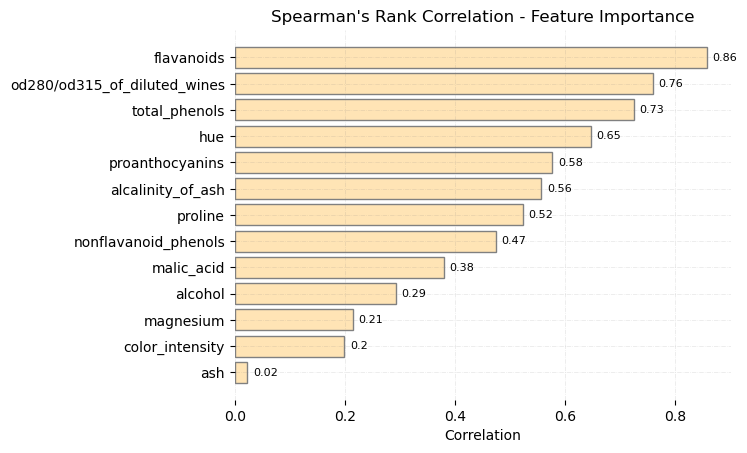

In [89]:
plt.rcdefaults()

fig, ax = plt.subplots()
ax.barh(my_spearman_df.Column, my_spearman_df.Correlation_To_Target, color='moccasin',  edgecolor='gray')
ax.set_yticklabels(my_spearman_df.Column)
ax.invert_yaxis()  # labels read top-to-bottom
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
for y, x in enumerate(my_spearman_df.Correlation_To_Target):
    plt.annotate(str(round(x,2)), xy=(x+0.01, y), va='center', fontsize=8)
for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)
ax.set_xlabel('Correlation')
ax.set_title("Spearman's Rank Correlation - Feature Importance")

plt.show()

By adding the values at the end of bar, it's cleaner and much easier to see how exactly the importance of each feature differs. 

According to Spearman's Correlation Coefficient, "flavanoids" is the most important feature contributing to predicting/classifying the Target column.

Spearman's Correlation has a great ability to confirm the strength of relationship for both parametric and non-parametric data and is particularly useful when a scattergram for initial EDA appears ambiguous. However, correlation does not equal causation, and while this technique gives a numerical value to a relationship, it doesn't tell us WHY that relationship may exist.

## Principal Component Analysis (PCA)

The goal of PCA is to transform a large dataset with a large number of features into a smaller one that still contains most of the information that was in the initial large dataset. Although reducing the number of features could result in lower accuracy, dealing with smaller, simpler data may create a better final model. 

1. Standardize the data to make sure all variables are on the same scale. 
2. Compute covariance matrix to understand how the features vary with respect to each other and the mean.
If features are codependent (highly correlated with each other), then the model will contain redundant information. If the sign of the value in the matrix is positive, then two variables are correlated. When one increases, so does the other, and vice versa. If the sign is negative, then the 2 variables are inversely correlated. When one increases, the other decreases. 
3. Compute eigenvectors and eigenvalues to determine principal components.
Principal components are uncorrelated new variables that are constructed as combinations of the initial variables. Most of the information (percentage of explained variances) from the large dataset compressed into the first few components. For example, if there are 7 principal components, the most important info will be in the 1st component, followed by the 2nd, etc. 

The eigenvectors are "the directions of the axes where there is the most variance(most information)," which we call Principal Components. The eigenvalues are simply the "coefficients attached to eigenvectors, which give the amount of variance carried in each Principal Component."

When we rank the eigenvectors in order of their respective eigenvalues, we get the components in order of significance.

I did not implement this function myself; rather, I used the PCA function from Sklearn.

In [93]:
# initialize scaler to normalize values in train and test
scaler = StandardScaler()
col_list = []
for column in train.columns:
    if column != 'target':
        col_list.append(column)
scaled_train = scaler.fit_transform(train.loc[:, col_list])
scaled_val = scaler.transform(val.loc[:, col_list])

In [95]:
pca = PCA(n_components=0.99, random_state=42)
pca.fit(scaled_train)

# viewing the coeffs of the 1st component
first_comp = abs(pca.components_[0])
print(first_comp)

[0.14437334 0.2337447  0.00706511 0.2235901  0.15184439 0.39439159
 0.429506   0.29140435 0.31334896 0.09640988 0.29685959 0.38316219
 0.28993558]


In [97]:
# creating dictionary of importances
pca_dict = {col_list[i]:first_comp[i] for i in range(len(col_list))}
pca_copy = dict(sorted(pca_dict.items(), key=lambda x: x[1], reverse=True))
pca_df = pd.DataFrame(list(pca_copy.items()),columns = ['Column','Importance'])

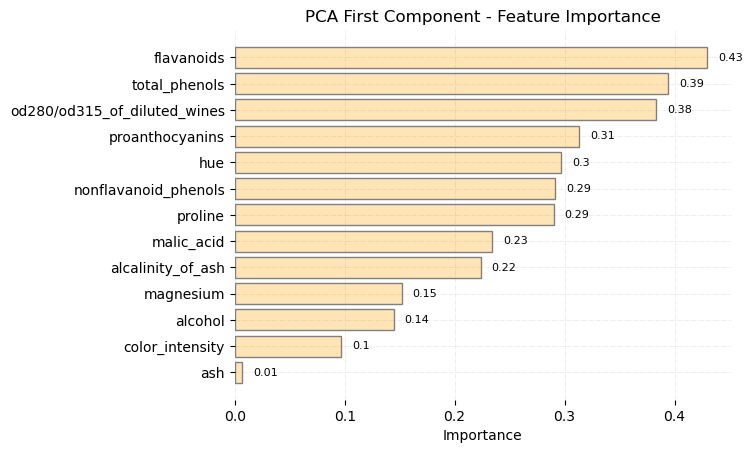

In [98]:
plt.rcdefaults()

fig, ax = plt.subplots()
ax.barh(pca_df.Column, pca_df.Importance, color='moccasin',  edgecolor='gray')
ax.set_yticklabels(pca_df.Column)
ax.invert_yaxis()  # labels read top-to-bottom
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
for y, x in enumerate(pca_df.Importance):
    plt.annotate(str(round(x,2)), xy=(x+0.01, y), va='center', fontsize=8)
for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)
ax.set_xlabel('Importance')
ax.set_title("PCA First Component - Feature Importance")

plt.show()

According to PCA, "flavanoids" is the most important feature contributing to predicting/classifying the Target column, as Spearman's also said. Malic Acid is 8th in terms of importance, compared to 9th from my Spearman function and 10th with the Pandas corr function.

## Permutation Importance

Permutation Importance is a model-based importance technique that is calculated after the model has been fitted. The following, taken from Kaggle, details the process:

1. Train the model
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

In other words, "If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?" - https://www.kaggle.com/dansbecker/permutation-importance

I'll be returning an initial baseline metric from a Random Forest model trained on the whole data. By permuting (ie. shuffling) the columns one by one, we can perceive the change in the chosen metric - accuracy_score. This technique is very fast to calculate.

In [105]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train.loc[:, col_list], train.target)
pred_val = rf.predict(val.loc[:, col_list])
pred_train = rf.predict(train.loc[:, col_list])

In [106]:
acc_train = accuracy_score(train.target, pred_train)
acc_val = accuracy_score(val.target, pred_val)
print(f'train accuracy: {acc_train:.3f} validation accuracy: {acc_val:.3f}')

train accuracy: 1.000 validation accuracy: 1.000


### Manual Permutation Importance

In [108]:
my_func_perm = permutation_importance(rf, val=val, target='target')

In [110]:
# changing dictionary to dataframe for easier plotting
perm_df = pd.DataFrame(list(my_func_perm.items()),columns = ['Column','Importance'])

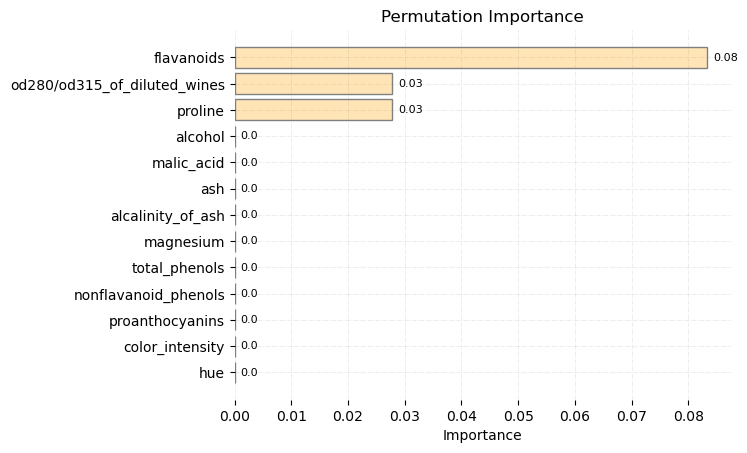

In [113]:
plt.rcdefaults()

fig, ax = plt.subplots()
ax.barh(perm_df.Column, perm_df.Importance, color='moccasin',  edgecolor='gray')
ax.set_yticklabels(perm_df.Column)
ax.invert_yaxis()  # labels read top-to-bottom
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
for y, x in enumerate(perm_df.Importance):
    plt.annotate(str(round(x,2)), xy=(x+0.001, y), va='center', fontsize=8)
for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)
ax.set_xlabel('Importance')
ax.set_title("Permutation Importance")

plt.show()

### Eli5 Sklearn Permutation Importance 

In [115]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=42).fit(val.loc[:, col_list], val.target)
eli5.show_weights(perm, feature_names = val.loc[:, col_list].columns.tolist())

Weight,Feature
0.0611 ± 0.0648,flavanoids
0.0444 ± 0.0444,proline
0.0389 ± 0.0444,color_intensity
0.0333 ± 0.0416,alcohol
0.0167 ± 0.0272,od280/od315_of_diluted_wines
0.0167 ± 0.0272,hue
0 ± 0.0000,proanthocyanins
0 ± 0.0000,nonflavanoid_phenols
0 ± 0.0000,total_phenols
0 ± 0.0000,magnesium


We can see that both my function and the automated Sklearn function rated Flavanoids as most important and Malic Acid as unimportant - this tells me that shuffling the Malic Acid values while keeping the other column values the same did not affect target prediction and increase model error. While PCA and Spearman's rated Proline in the middle, both permutation importance functions rated it more important than other features. One issue with Permutation Importance, however, is that features can be highly-ranked just because they’re just correlated with other highly-ranked features.

## Drop Column Importance 

Drop Column Importance is another model-based feature importance technique that drops a feature each iteration and measures how drastically the model error is affected. The model is retrained with each iteration which can be very computationally expensive. 

In [148]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(train.loc[:, col_list], train.target)
pred_val = rf.predict(val.loc[:, col_list])
pred_train = rf.predict(train.loc[:, col_list])

In [149]:
acc_train = accuracy_score(train.target, pred_train)
acc_val = accuracy_score(val.target, pred_val)
print(f'train accuracy: {acc_train:.3f} validation accuracy: {acc_val:.3f}')

train accuracy: 1.000 validation accuracy: 1.000


### Manual Drop Column Importance

In [156]:
my_drop_func = dropcolumn_importances(rf=rf, df1=train, target='target', random_state=42)

In [159]:
# changing dictionary to dataframe for easier plotting
dropcol_df = pd.DataFrame(list(my_drop_func.items()),columns = ['Column','Importance'])

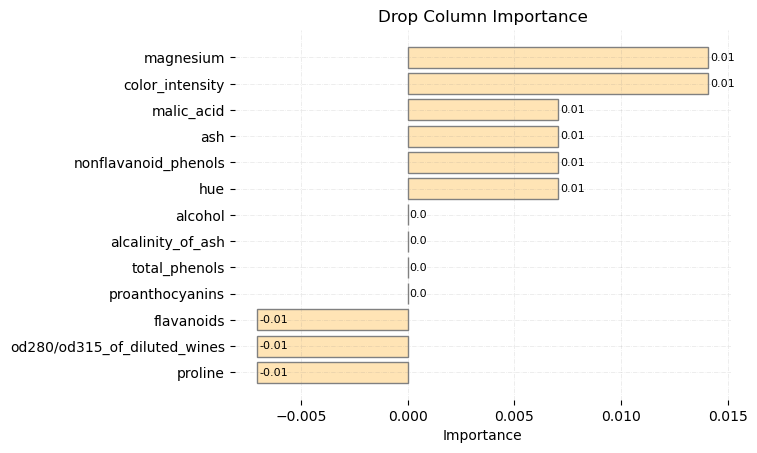

In [162]:
plt.rcdefaults()

fig, ax = plt.subplots()
ax.barh(dropcol_df.Column, dropcol_df.Importance, color='moccasin',  edgecolor='gray')
ax.set_yticklabels(dropcol_df.Column)
ax.invert_yaxis()  # labels read top-to-bottom
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
for y, x in enumerate(dropcol_df.Importance):
    plt.annotate(str(round(x,2)), xy=(x+0.0001, y), va='center', fontsize=8)
for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)
ax.set_xlabel('Importance')
ax.set_title("Drop Column Importance")

plt.show()

Negative importance is actually good in the case of this technique, meaning removing flavanoids, od280/od315, and proline individually caused better model performance. This same top 3 was present in Permutation Importance as well. The removal of Malic Acid did not cause any changes in the model, and may in fact have decreased it's performance.  

The RFPimp package has drop column and permutation importance packages as well. 

## Shap (SHapley Additive exPlanations)

SHAP values "interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value." In other words, for the wine dataset, we could ask a question like "How much was a prediction driven by the fact that there was 1.71oz of Malic Acid versus some other baseline amount?" This makes it easier to give a more concrete, numeric answer for business issues. 

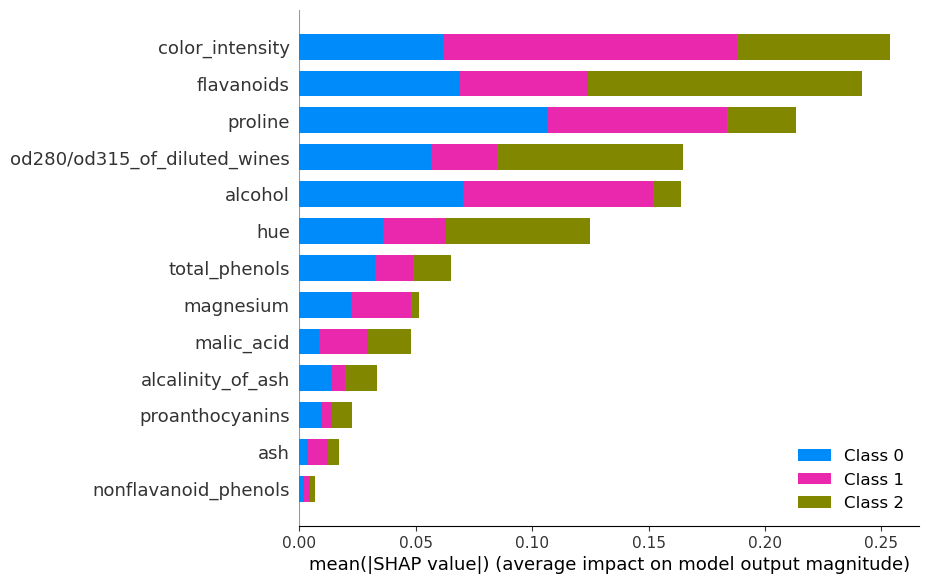

In [188]:
explainer = shap.TreeExplainer(rf, data=train.drop(columns='target'))
shap_values = explainer.shap_values(X=val.drop(columns='target'), y=val['target'], check_additivity=False)
shap.summary_plot(shap_values, val.drop(columns='target'), plot_type="bar")

This figure tells us how much each feature affects the target classification. For example, Color Intensity is the feature which tends to classify targets as Class 1 the most, while flavonoids classifies Class 2 more. We can see going down the graph that the color bars even out until the features equally predict each class, meaning that feature is not very important to the model.

## Automatic Feature Selection

The Automatic Feature Selection algorithm does exactly what it is named - automatically drop off unimportant features while keep the features that give the best validation error. We start by getting a baseline validation metric; since this is a multi-class classification problem, I chose log-loss. We then calculate the importances and drop the lowest importance feature. We retrain the model on the features that have not been dropped and recompute log-loss. We can see that if log-loss decreases, too many features have been dropped. This means the previous model is our most optimal.

In [210]:
rf = RandomForestClassifier(n_estimators=30, random_state=42)
model, dropped_features = automatic_feature_selection(model=rf, train=train, val=val)

Iter 1: dropping feature: nonflavanoid_phenols
Loss in last iter: 0.115, loss in this iter: 0.106
Loss decreased hence continuing to drop more features
Iter 2: dropping feature: ash
Loss in last iter: 0.106, loss in this iter: 0.105
Loss decreased hence continuing to drop more features
Iter 3: dropping feature: proanthocyanins
Loss in last iter: 0.105, loss in this iter: 0.110
Stopping iterations as loss did not decrease, dropped features = ['nonflavanoid_phenols', 'ash']


From this automatic feature selection code, loss decreased when nonflavanoid_phenols and ash were dropped but increased when Proanthocyanins was dropped, meaning we revert to the model where only nonflavanoid_phenols and ash were dropped. Based on these results, proanthocyanins is important to the model.  

## Other Techniques - mRMR and p-values

mRMR (Minimum Redundancy Maximum Relevance) are a family of feature selection algorithms that can be applied to a vast variety of problem sectors. Its aim is to select features that have a high correlation to the target variable but are also individually far from each other. In other words, Maximum Relevance to the target variable and Minimum Redundancy in comparison to the other independent features so as to not give the model redundant information. In this technique, the only thing set by the user is the number of feature they want to keep. It iteratively identifies the "best feature" and adds it to the bucket of permanently selected features. The best feature at iteration i is the one having the highest relavancy score. It is quick to implement, as well as effective in any pipeline. 

P-values are not only the crux of statistics but also a great way to know whether a feature's importance is significant. Once we fit a model with all features included, we can check the p-values of each feature. The basic premise is that if the p-value is greater than the significance level (baseline true feature importance) a certain amount of time, the feature is not significant and can be dropped. We want to be left with only the features that contain a p-value less than or equal to the significance level.

## Conclusion

In summary, feature selection is a crucial part of the Machine Learning pipeline. Keeping superfluous features can negatively affect the final model's performance. Performing feature selection before data modeling can reduce overfitting by getting rid of redundant data, improve accuracy by dropping codependent and misleading features, and reduce training time by decreasing algorithm complexity. 

## References

- https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf
- https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/
- https://builtin.com/data-science/step-step-explanation-principal-component-analysis
- https://www.kaggle.com/dansbecker/permutation-importance
- https://towardsdatascience.com/feature-importance-may-be-lying-to-you-3247cafa7ee7#:~:text=Drop%2Dcolumn%20Importance%20is%20exactly,it%20will%20still%20be%20slow.
- https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
- https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b